## **El clustering aglomerativo**

El clustering aglomerativo  es un algoritmo jerárquico de clustering que comienza tratando cada punto como un clúster independiente y, a continuación, fusiona de forma iterativa los dos grupos más cercanos hasta alcanzar el número de clústeres deseado. En scikit-learn, ese parámetro se llama `n_clusters`, de modo que el proceso de fusión continúa hasta que solo quedan tantos grupos como se haya especificado al instanciar `AgglomerativeClustering`.

Para decidir qué dos clústeres son "los más cercanos", scikit-learn ofrece distintos criterios de enlace (linkage). El enlace por defecto, `ward`, selecciona en cada paso el par cuya fusión incrementa lo menos posible la suma de varianzas internas, lo cual suele dar lugar a grupos de tamaño y dispersión relativamente homogéneos. Si, por el contrario, los clústeres presentan un número de puntos muy desigual o formas irregulares, puede convenir probar el enlace `average`, que calcula la distancia media entre todos los pares de puntos de dos clústeres, o el enlace `complete` (también llamado enlace máximo), que se basa en la distancia máxima entre puntos y tiende a producir clústeres más compactos y bien separados.

Además de `linkage`, otro parámetro importante es la métrica de distancia, que en versiones recientes de scikit-learn se denomina `metric` (antes `affinity`). Con `ward` solo es válida la métrica euclídea, pero si usamos `average` o `complete` podemos optar por “manhattan”, “cosine” u otras distancias soportadas. También existe la opción `connectivity`, que permite imponer un grafo de vecindad sobre los datos; resulta útil cuando sabemos que solo ciertos puntos deberían considerarse vecinos (por ejemplo, datos espaciales o estructurados en red).

En la práctica, la implementación es muy sencilla: basta crear una instancia de `AgglomerativeClustering` con `n_clusters=4`, `linkage="average"` y `metric="manhattan"`, y luego llamar a `fit_predict(X)` sobre nuestra matriz de datos `X`. Si queremos entender mejor la jerarquía resultante, podemos pasar los mismos datos a `scipy.cluster.hierarchy.linkage` (por ejemplo con `method="complete"`) y luego dibujar un dendrograma con `dendrogram(Z)`, lo cual proporciona una representación gráfica muy intuitiva de las sucesivas fusiones.

El principal beneficio del clustering aglomerativo es que no requiere asumir ninguna forma concreta de clúster y permite explorar distintos niveles de granularidad gracias a la jerarquía inherente. Sin embargo, su coste es cuadrático tanto en tiempo como en memoria, lo cual lo hace poco escalable para conjuntos de datos muy grandes. Además, resulta sensible al ruido y a los valores atípicos, que pueden modificar drásticamente la estructura de fusiones tempranas.

En resumen, para datos de tamaño moderado y con cierta homogeneidad, `ward` suele ser la mejor opción, mientras que `average` o `complete` pueden funcionar mejor cuando esperamos clústeres de tamaños muy distintos o formas no esféricas. Incorporar métricas distintas o restricciones de conectividad amplía aún más las posibilidades, permitiéndonos adaptar el algoritmo a la naturaleza particular de nuestros datos.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity


def dibuja_algoritmo_aglomerativo():
    # generamos datos artificiales dos dimensionales
    X, y = make_blobs(random_state=0, n_samples=12)
    agg = AgglomerativeClustering(n_clusters=X.shape[0], compute_full_tree=True).fit(X)
    fig, axes = plt.subplots(X.shape[0] // 5, 5, subplot_kw={'xticks': (),
                                                             'yticks': ()},
                             figsize=(20, 8))

    eps = X.std() / 2

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    puntos_grid = np.c_[xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)]

    for i, ax in enumerate(axes.ravel()):
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        agg.n_clusters = X.shape[0] - i
        agg.fit(X)
        ax.set_title("Paso %d" % i)
        ax.scatter(X[:, 0], X[:, 1], s=60, c='grey')
        bins = np.bincount(agg.labels_)
        for cluster in range(agg.n_clusters):
            if bins[cluster] > 1:
                puntos = X[agg.labels_ == cluster]
                otros_puntos = X[agg.labels_ != cluster]

                kde = KernelDensity(bandwidth=.5).fit(puntos)
                puntuacion = kde.score_samples(puntos_grid)
                puntuacion_1 = np.min(kde.score_samples(puntos))
                puntuacion_2 = np.max(kde.score_samples(otros_puntos))
                niveles = .8 * puntuacion_1 + .2 * puntuacion_2
                ax.contour(xx, yy, puntuacion.reshape(100, 100), levels=[niveles],
                           colors='k', linestyles='solid', linewidths=2)

    axes[0, 0].set_title("Inicializacion")


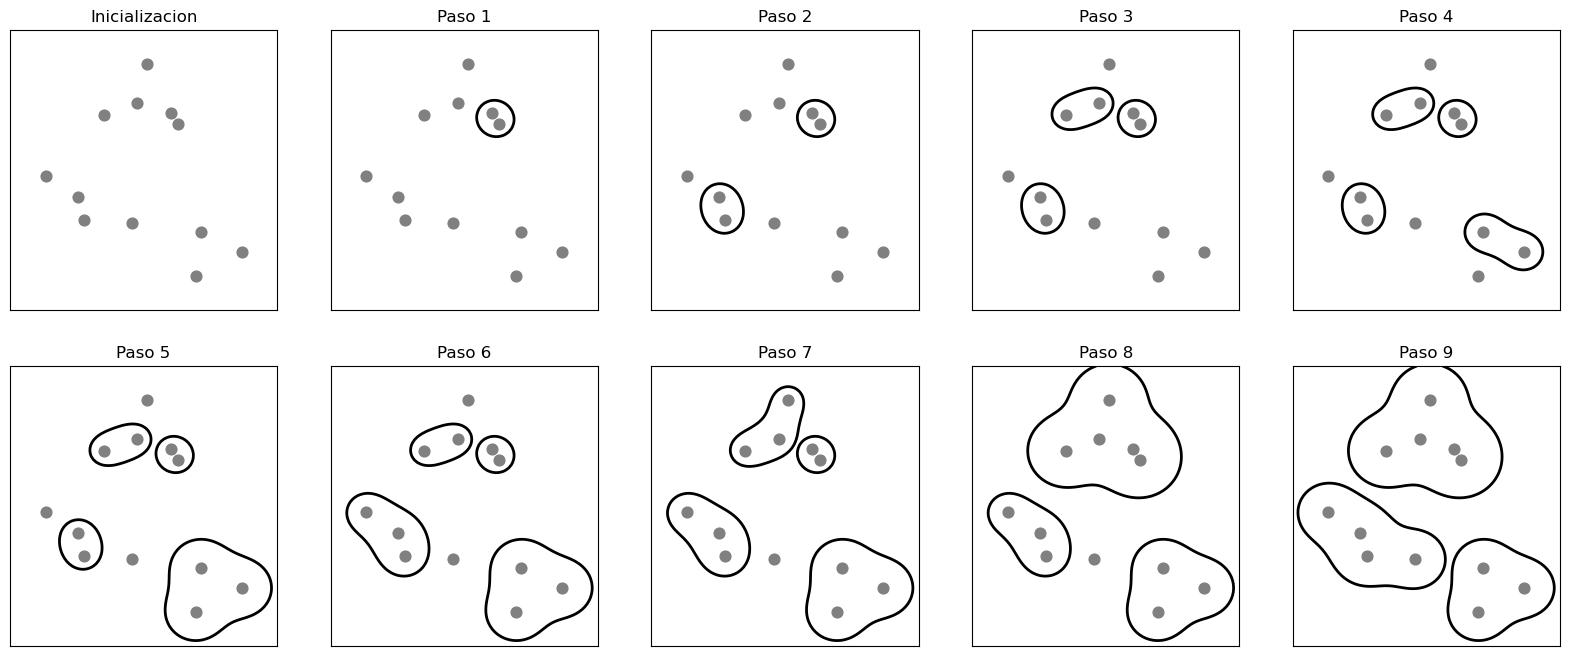

In [3]:
dibuja_algoritmo_aglomerativo()

Al principio, cada punto forma su propio clúster. Luego, en cada iteración, se fusionan los dos grupos más cercanos. En los cuatro primeros pasos, siempre se unen dos clústeres de un solo punto para formar clústeres de dos puntos. En el paso 5, uno de esos clústeres de dos puntos incorpora un tercer punto, y así sucesivamente. Cuando llegamos al paso 9, solo quedan tres clústeres; como habíamos fijado `n_clusters=3`, el algoritmo se detiene.

Veamos ahora cómo opera el clustering aglomerativo con un conjunto muy simple de tres clústeres de datos. Dado que este método es puramente jerárquico, **no** puede asignar nuevos puntos tras el entrenamiento; por ello, la clase `AgglomerativeClustering` de scikit-learn **no** implementa un método `predict`. En su lugar, para ajustar el modelo y obtener las etiquetas de cada muestra, usamos `fit_predict(X)`.

**Función auxiliar**

In [5]:
import matplotlib as mpl
from matplotlib.colors import  colorConverter

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

Text(0, 0.5, 'Caracteristica 1')

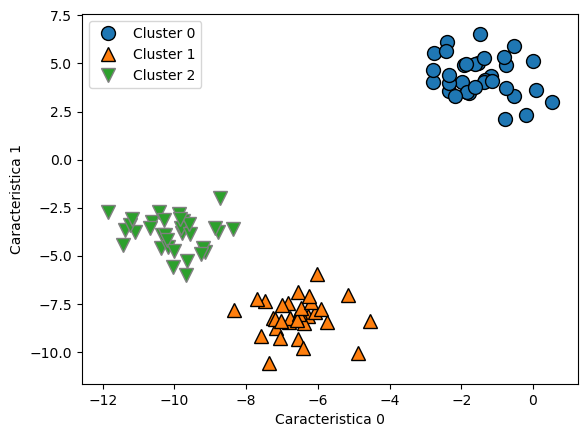

In [6]:
from sklearn.cluster import AgglomerativeClustering
X, y = make_blobs(random_state=1)
agg = AgglomerativeClustering(n_clusters=3)
asignamiento = agg.fit_predict(X)
dibuja_dispersion_discreta(X[:, 0], X[:, 1], asignamiento)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

Como era de esperar, el algoritmo recupera la agrupación de forma perfecta. Aunque la implementación de clustering aglomerativo en scikit-learn exige especificar de antemano el número de clústeres que debe encontrar, existen métodos que nos ayudan a elegir dicho número, como veremos a continuación.

### **Clustering jerárquico y dendrograma**

El clustering aglomerativo genera lo que llamamos un **clustering jerárquico**, en el que cada punto inicia formando su propio clúster y, paso a paso, se va incorporando a grupos cada vez más grandes hasta llegar a la partición final. En cada iteración obtenemos una partición intermedia con distinto número de clústeres, que refleja hasta qué nivel de detalle estamos observando la estructura de los datos.

Para visualizar de un solo vistazo todas esas fusiones sucesivas resulta muy útil el **dendrograma**, un diagrama en forma de árbol invertido que muestra en el eje vertical la distancia (o disimilitud) a la que se unen los clústeres y, en el horizontal, los elementos o subgrupos resultantes. De este modo, podemos identificar de forma intuitiva:

* **El umbral de corte**: basta trazar una línea horizontal a la altura deseada para elegir el número de clústeres que nos interese.
* **La cohesión interna**: la altura de las ramas del dendrograma indica qué tan similares eran dos clústeres antes de fusionarse; fusiones a menor altura significan grupos muy homogéneos.
* **La estabilidad de los grupos**: clústeres que permanecen unidos hasta niveles altos del dendrograma son más robustos frente a variaciones en la métrica de distancia.

En conjunto, el dendrograma no solo facilita la determinación del número óptimo de clústeres, sino que también proporciona una visión clara de la estructura jerárquica y de la forma en que los datos se agrupan a distintas escalas.


In [9]:
# Asignación de cluster jerarquico (mostrado como lineas) generado con clustering aglomerativo, con puntos de datos numerados
def dibuja_cluster_aglomerativo():
    X, y = make_blobs(random_state=0, n_samples=12)
    agg = AgglomerativeClustering(n_clusters=3)

    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    puntos_grid = np.c_[xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)]

    ax = plt.gca()
    for i, x in enumerate(X):
        ax.text(x[0] + .1, x[1], "%d" % i, horizontalalignment='left', verticalalignment='center')

    ax.scatter(X[:, 0], X[:, 1], s=60, c='grey')
    ax.set_xticks(())
    ax.set_yticks(())

    for i in range(11):
        agg.n_clusters = X.shape[0] - i
        agg.fit(X)

        bins = np.bincount(agg.labels_)
        for cluster in range(agg.n_clusters):
            if bins[cluster] > 1:
                puntos = X[agg.labels_ == cluster]
                otros_puntos = X[agg.labels_ != cluster]

                kde = KernelDensity(bandwidth=.5).fit(puntos)
                puntuaciones = kde.score_samples(puntos_grid)
                puntuaciones1 = np.min(kde.score_samples(puntos))
                puntuaciones2 = np.max(kde.score_samples(otros_puntos))
                niveles = .8 * puntuaciones1 + .2 * puntuaciones2
                ax.contour(xx, yy, puntuaciones.reshape(100, 100), levels=[niveles],
                           colors='k', linestyles='solid', linewidths=1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

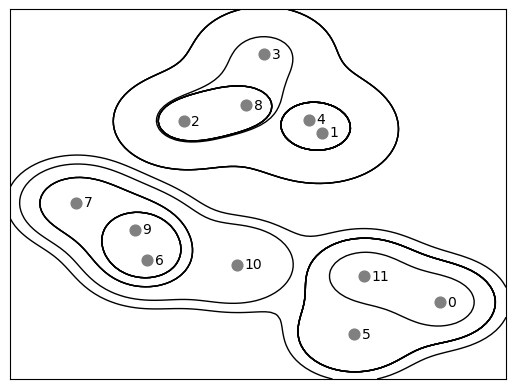

In [10]:
dibuja_cluster_aglomerativo()

Aunque esta visualización ofrece un detalle muy fino del clustering jerárquico, se apoya en la representación bidimensional de los datos y, por tanto, no resulta válida cuando tenemos más de dos variables. Sin embargo, existe otra forma de visualizar la estructura jerárquica que sí admite datos multidimensionales: el dendrograma.


Los algoritmos de clustering de SciPy utilizan una interfaz ligeramente distinta a la de scikit-learn y están diseñados, entre otras cosas, para generar dendrogramas. SciPy ofrece una función que recibe la matriz de datos `X` y devuelve una **matriz de enlaces** (linkage matrix), en la que se codifica la similitud jerárquica entre clústeres. Seguidamente, esa matriz de enlaces se pasa a la función `dendrogram` de SciPy para dibujar el dendrograma.


Text(0, 0.5, 'Distancia de clusters')

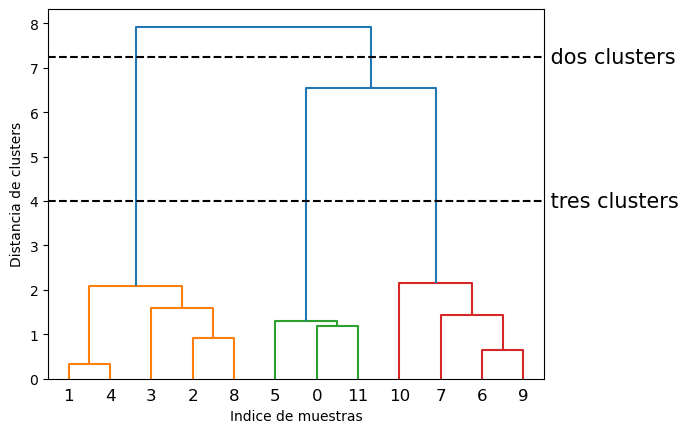

In [13]:
# Importamos la funcion  dendrogram  y la funcion ward desde SciPy
from scipy.cluster.hierarchy import dendrogram, ward


X, y = make_blobs(random_state=0, n_samples=12)
# Aplique el clustering  ward a la matriz de datos X. 
matriz_enlace = ward(X)

# Graficamos el dendrograma para la matriz enlace que contiene las distancias entre clusters
dendrogram(matriz_enlace)

# Marca los cortes en el árbol que significan dos o tres grupos

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')
ax.text(bounds[1], 7.25, ' dos clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' tres clusters', va='center', fontdict={'size': 15})
plt.xlabel("Indice de muestras")
plt.ylabel("Distancia de clusters")


El dendrograma muestra los puntos de datos como hojas numeradas de 0 a 11 en la base, y sobre ellas se construye un árbol en el que cada fusión genera un nodo padre que une dos clústeres. El eje vertical (`y`) indica tanto el orden de fusiones en el algoritmo como la distancia entre los clústeres fusionados: cuanto más larga es una rama, mayor es la separación original entre esos grupos.

En este ejemplo, las tres ramas más largas (marcadas con la línea discontinua y la etiqueta "tres grupos") señalan que pasar de tres a dos clústeres implica unir subgrupos muy distantes. Esta idea se refuerza en la parte superior del dendrograma, donde la última fusión, la que consolida los dos clústeres restantes en uno solo ocurre a una distancia especialmente elevada.

A pesar de su utilidad para visualizar estructuras jerárquicas, la agrupación aglomerativa puede fallar al separar formas complejas, como el conjunto de datos `two_moons`. Para esos casos, algoritmos basados en densidad, como DBSCAN, suelen ofrecer resultados mucho mejores.


### **DBSCAN**

DBSCAN (del inglés *Density-Based Spatial Clustering of Applications with Noise*) es un algoritmo de clustering que no exige especificar de antemano el número de clústeres. Además, es capaz de detectar grupos de formas arbitrarias y de identificar puntos aislados ("ruido") que no pertenecen a ningún clúster. Aunque suele ser algo más lento que K-means o el clustering aglomerativo, escala razonablemente bien a conjuntos de datos de tamaño medio.

La idea central de DBSCAN es que los clústeres son regiones densas de puntos, separadas por zonas de baja densidad. Para ello define dos parámetros:

* `eps`: radio de búsqueda, la distancia máxima para considerar dos puntos vecinos.
* `min_samples`: número mínimo de puntos que debe haber dentro de la bola de radio `eps` para que un punto se considere “central”.

Con estos parámetros, DBSCAN clasifica cada punto en uno de tres tipos:

1. **Core sample** (punto central)
   Tiene al menos `min_samples` vecinos a distancia ≤ `eps`.
2. **Border point** (punto frontera)
   No alcanza `min_samples` vecinos por sí solo, pero está dentro de `eps` de algún core sample.
3. **Noise** (ruido)
   No es ni core sample ni frontera; no pertenece a ningún clúster.

**Proceso de DBSCAN**

1. Se elige un punto no visitado.
2. Se cuentan sus vecinos (distancia ≤ `eps`).

   * Si son < `min_samples`, se etiqueta como ruido.
   * Si son ≥ `min_samples`, se crea un nuevo clúster y se etiqueta como core sample.
3. Se expanden los clústeres recorriendo recursivamente los vecinos de cada core sample:

   * A cada vecino no asignado se le pone la etiqueta del clúster.
   * Si ese vecino también es core sample, se analizan sus vecinos, y así hasta agotar la expansión.
4. Se repite el proceso con otro punto no visitado hasta cubrir todo el conjunto.

Al final obtenemos clústeres que reflejan la densidad real de los datos y un conjunto de puntos etiquetados como ruido. Ten en cuenta que, aunque la clasificación de los core samples y del ruido es determinista, la asignación de los puntos frontera puede depender del orden en que se exploran los vecinos. Sin embargo, en la práctica esto suele afectar solo a un pequeño número de puntos y rara vez altera de forma significativa la partición final.

En scikit-learn, la clase `DBSCAN` no implementa un método `predict` para nuevos datos; en su lugar se utiliza `fit_predict(X)` para ajustar y etiquetar en un solo paso.


In [16]:
from sklearn.cluster import DBSCAN
X, y = make_blobs(random_state=0, n_samples=12)
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Miembros de los clustering:\n{}".format(clusters))

Miembros de los clustering:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


Todos los puntos de datos se les asignó la etiqueta `-1`, que significa ruido. Esto es una consecuencia de los ajustes de parámetros predeterminados para `eps` y `min_samples`, que no están ajustados para conjuntos de datos pequeños. 

Las asignaciones de clúster para diferentes valores de `min_samples` y `eps` se muestran a continuación y se visualizan:

In [18]:
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap

cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])


def dibuja_dbscan():
    X, y = make_blobs(random_state=0, n_samples=12)

    dbscan = DBSCAN()
    clusters = dbscan.fit_predict(X)
    clusters

    fig, axes = plt.subplots(3, 4, figsize=(11, 8),
                             subplot_kw={'xticks': (), 'yticks': ()})
    
    # dibujamos  los clústeres como rojo, verde y azul, y los valores atípicos (-1) con blanco

    colores = [cm3(1), cm3(0), cm3(2)]
    marcadores = ['o', '^', 'v']

    # iterar sobre la configuración de min_samples y eps
    for i, min_samples in enumerate([2, 3, 5]):
        for j, eps in enumerate([1, 1.5, 2, 3]):
            # instanciado  DBSCAN con una configuracion particular
            dbscan = DBSCAN(min_samples=min_samples, eps=eps)
            # obtenemos asignacion de cluster
            clusters = dbscan.fit_predict(X)
            print("min_samples: %d eps: %f  cluster: %s"
                  % (min_samples, eps, clusters))
            if np.any(clusters == -1):
                c = ['w'] + colores
                m = ['o'] + marcadores
            else:
                c = colores
                m = marcadores
            dibuja_dispersion_discreta(X[:, 0], X[:, 1], clusters, ax=axes[i, j], c=c,
                             s=8, marcadores=m)
            inds = dbscan.core_sample_indices_
            # vizualizamos los  core samples y clusters.
            if len(inds):
                dibuja_dispersion_discreta(X[inds, 0], X[inds, 1], clusters[inds], ax=axes[i, j], s=15, c=colores,
                                 marcadores=marcadores)
            axes[i, j].set_title("min_samples: %d eps: %.1f"
                                 % (min_samples, eps))
    fig.tight_layout()

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


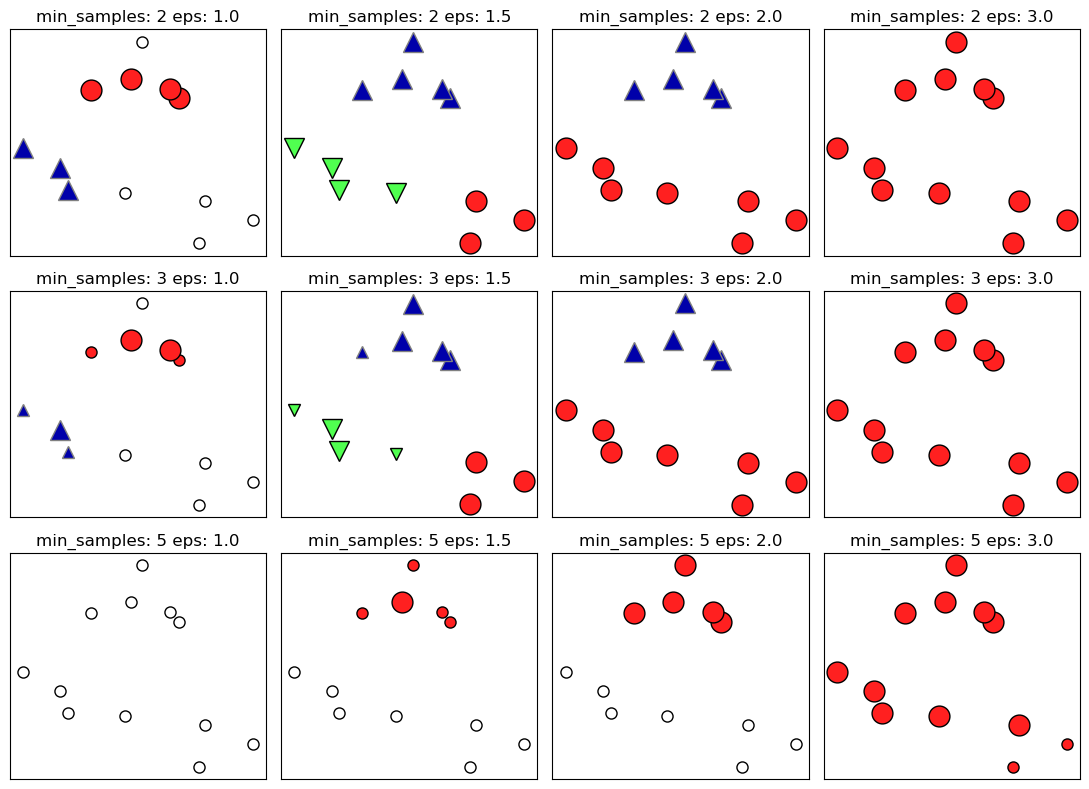

In [19]:
dibuja_dbscan()

En este gráfico, los puntos que pertenecen a los clústeres aparecen rellenos, mientras que los de ruido se muestran en blanco. Los *core samples* se dibujan con marcadores grandes y los puntos frontera con marcadores más pequeños. Al aumentar el valor de `eps` (de izquierda a derecha), más puntos entran en la vecindad de cada core sample, lo que hace crecer los clústeres, aunque también puede provocar que varios se fusionen en uno solo. Por otro lado, incrementar `min_samples` (de arriba abajo) exige un mayor número de vecinos para definir un core sample, de modo que menos puntos se clasifican como centrales y crece la cantidad de ruido.

El parámetro `eps` es crucial porque determina qué significa "cercanía": un `eps` demasiado pequeño hará que ningún punto alcance el umbral de core sample y que casi todos acaben etiquetados como ruido; un `eps` muy grande, en cambio, tenderá a agrupar todos los puntos en un único clúster.

Mientras tanto, `min_samples` regula el tamaño mínimo de los clústeres: valores mayores convierten en ruido los puntos en regiones menos densas, y valores menores permiten formar clústeres más pequeños antes de considerarlos ruido.

Aunque DBSCAN no requiere especificar el número de clústeres, la elección de `eps` influye indirectamente en cuántos se detectan. Por ello, resulta habitual escalar primero los datos con `StandardScaler` o `MinMaxScaler`, de modo que todas las características compartan un rango similar y resulte más fácil encontrar un valor de `eps` adecuado.



Text(0, 0.5, 'Caracteristica 1')

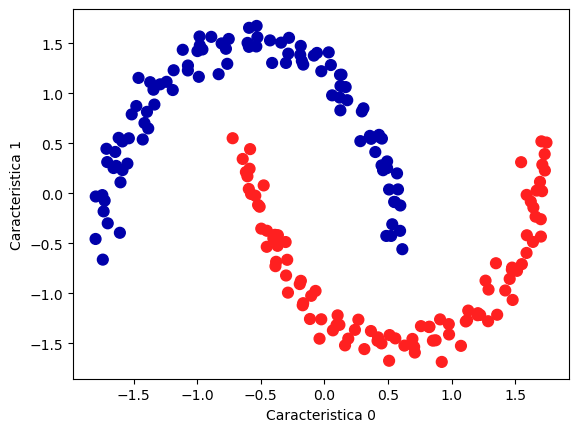

In [21]:
# Corremos DBSCAN con el conjunto de datos two_moons
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescalamos  los datos a una media cero y varianza 1 
escalador = StandardScaler()
escalador.fit(X)
X_escalado = escalador.transform(X)
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_escalado)

# dibujamos el asignamiento de clusters
plt.scatter(X_escalado[:, 0], X_escalado[:, 1], c=clusters, cmap=cm2, s=60)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

Como el algoritmo produjo el número deseado de clústeres (dos), la configuración de parámetros parece adecuada. Si reducimos `eps` a 0.2 (frente al valor por defecto de 0.5), obtenemos ocho clústeres, lo cual es excesivo. Por el contrario, aumentar `eps` a 0.7 da como resultado un único clúster.

Al usar DBSCAN, hay que prestar atención al manejo de las etiquetas devueltas. DBSCAN emplea `-1` para indicar ruido, y esto puede causar comportamientos inesperados si usamos esas etiquetas para indexar otras estructuras (como arrays o DataFrames).
